In [10]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from load_data import *

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, Activation, add, GlobalAvgPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam #.legacy works better on Mac
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [12]:
def ResNet18(input_shape, nclass=4):
    """
    build resnet-18 model using keras with TensorFlow backend.
    :param input_shape: input shape of network, default as (115,115,3)
    :param nclass: numbers of class(output shape of network), default as 4
    :return: resnet-18 model
    """
    input_ = Input(shape=input_shape)

    conv1 = conv2d_bn(input_, 64, kernel_size=(7, 7), strides=(2, 2))
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(conv1)

    conv2 = residual_block(64, 2, is_first_layer=True)(pool1)
    conv3 = residual_block(128, 2, is_first_layer=True)(conv2)
    conv4 = residual_block(256, 2, is_first_layer=True)(conv3)
    conv5 = residual_block(512, 2, is_first_layer=True)(conv4)

    pool2 = GlobalAvgPool2D()(conv5)
    output_ = Dense(nclass, activation='softmax')(pool2)

    model = Model(inputs=input_, outputs=output_)

    return model


def conv2d_bn(x, nb_filter, kernel_size, strides=(1, 1), padding='same'):
    """
    conv2d -> batch normalization -> relu activation
    """
    x = Conv2D(nb_filter, kernel_size=kernel_size,
               strides=strides,
               padding=padding,
               kernel_regularizer=regularizers.l2(0.0001))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def shortcut(input, residual):
    """
    shortcut, identity mapping
    """

    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_height = int(round(input_shape[1] / residual_shape[1]))
    stride_width = int(round(input_shape[2] / residual_shape[2]))
    equal_channels = input_shape[3] == residual_shape[3]

    identity = input
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        identity = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_regularizer=regularizers.l2(0.0001))(input)

    return add([identity, residual])


def basic_block(nb_filter, strides=(1, 1)):
    """
    ResNet building block
    """

    def f(input):
        conv1 = conv2d_bn(input, nb_filter, kernel_size=(3, 3), strides=strides)
        residual = conv2d_bn(conv1, nb_filter, kernel_size=(3, 3))

        return shortcut(input, residual)

    return f


def residual_block(nb_filter, repetitions, is_first_layer=False):
    """
    residual; conv2_x -> conv5_x
    """

    def f(input):
        for i in range(repetitions):
            strides = (1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2)
            input = basic_block(nb_filter, strides)(input)
        return input

    return f

In [13]:
def train_resnet_model(X_train, y_train, X_eval, y_eval, num_classes=4):
    IMAGE_SIZE = X_train.shape[1] # extract the image size from the training data
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    model = ResNet18(input_shape=input_shape, classes=num_classes) #initialize the architecture

    
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss=SparseCategoricalCrossentropy(),
        metrics=["accuracy"]
    ) # compile the model with a smaller learning rate to prevent large fluctuations during training, 1e-4 caused very unstable training

    # set up early stopping to monitor validation accuracy and allow for early termination of training with best weight restoration
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

    # train the model using the provided training data and validate with the evaluation data
    history = model.fit(
        X_train, y_train,
        batch_size=32,
        epochs=15,
        validation_data=(X_eval, y_eval),
        callbacks=[early_stopping]
    )
    
    return model, history, X_eval, y_eval


In [5]:
img_shape = (225, 225)

results = {
    "models": [],
    "histories": [],
    "X_eval": [],
    "y_eval_cat": []
}

# Train on Augmented Dataset
images, labels, label_map = load_dataset(img_shape[0], img_shape[0])
X_train_aug, y_train_aug, X_eval, y_eval, X_test, y_test = split_and_augment_dataset(images, labels, eval_set=True, random_state=42)

num_classes = len(label_map)
num_layers_to_freeze = 50
model_aug, history_aug, X_eval_aug, y_eval_cat_aug = train_resnet_model(X_train_aug, y_train_aug, X_eval, y_eval, num_classes)

results["models"].append(model_aug)
results["histories"].append(history_aug)
results["X_eval"].append(X_eval_aug)
results["y_eval_cat"].append(y_eval_cat_aug)

# Train on Non-Augmented Dataset
X_non_aug, y_non_aug, _ = load_dataset(img_shape[0], img_shape[0])
X_train_non_aug, X_temp, y_train_non_aug, y_temp = train_test_split(X_non_aug, y_non_aug, test_size=0.4, random_state=42)
X_test_non_aug, X_eval_non_aug, y_test_non_aug, y_eval_non_aug = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

model_non_aug, history_non_aug, X_eval_non_aug, y_eval_cat_non_aug = train_resnet_model(X_train_non_aug, y_train_non_aug, X_eval_non_aug, y_eval_non_aug, num_classes)

results["models"].append(model_non_aug)
results["histories"].append(history_non_aug)
results["X_eval"].append(X_eval_non_aug)
results["y_eval_cat"].append(y_eval_cat_non_aug)


Epoch 1/15
709/709 [==============================] - 121s 151ms/step - loss: 1.0855 - accuracy: 0.7400 - val_loss: 1.0497 - val_accuracy: 0.7548
Epoch 2/15
709/709 [==============================] - 106s 149ms/step - loss: 0.8529 - accuracy: 0.8362 - val_loss: 0.9378 - val_accuracy: 0.7817
Epoch 3/15
709/709 [==============================] - 104s 147ms/step - loss: 0.7710 - accuracy: 0.8698 - val_loss: 1.1642 - val_accuracy: 0.7627
Epoch 4/15
709/709 [==============================] - 104s 147ms/step - loss: 0.7124 - accuracy: 0.8924 - val_loss: 0.9737 - val_accuracy: 0.7857
Epoch 5/15
709/709 [==============================] - 106s 149ms/step - loss: 0.6569 - accuracy: 0.9116 - val_loss: 1.7210 - val_accuracy: 0.6484
Epoch 6/15
709/709 [==============================] - 104s 147ms/step - loss: 0.6275 - accuracy: 0.9226 - val_loss: 1.0683 - val_accuracy: 0.7794
Epoch 7/15
709/709 [==============================] - 105s 148ms/step - loss: 0.5955 - accuracy: 0.9341 - val_loss: 1.1628 -

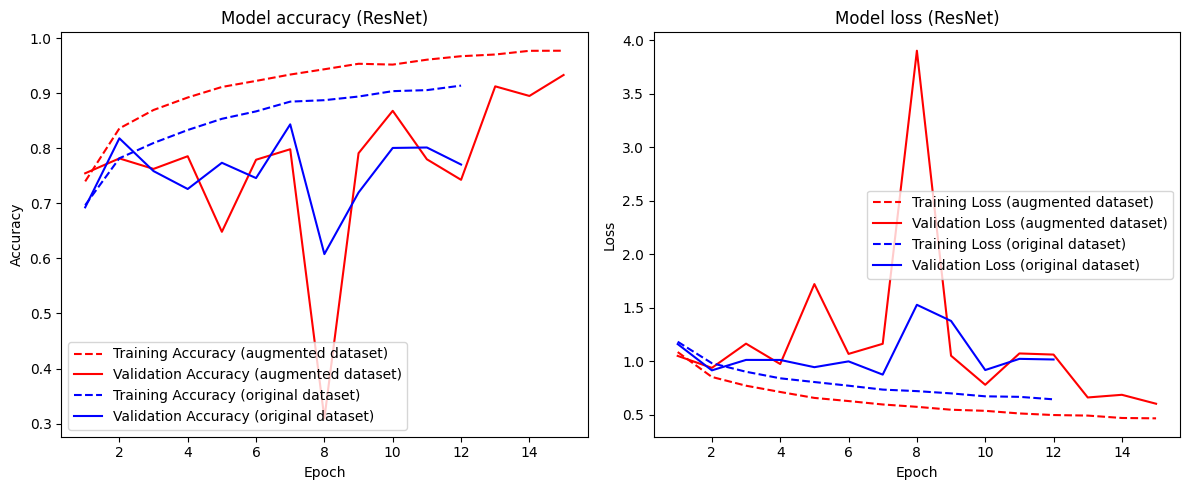

In [6]:
import matplotlib.pyplot as plt

def plot_training_results(results):
    plt.figure(figsize=(12, 5))

    for idx, dataset_type in enumerate(["augmented dataset", "original dataset"]):
        history = results["histories"][idx].history
        epochs = range(1, len(history['accuracy']) + 1)

        # Training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['accuracy'], 'r--' if dataset_type == "augmented dataset" else 'b--', label=f'Training Accuracy ({dataset_type})')
        plt.plot(epochs, history['val_accuracy'], 'r-' if dataset_type == "augmented dataset" else 'b-', label=f'Validation Accuracy ({dataset_type})')

        # Training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['loss'], 'r--' if dataset_type == "augmented dataset" else 'b--', label=f'Training Loss ({dataset_type})')
        plt.plot(epochs, history['val_loss'], 'r-' if dataset_type == "augmented dataset" else 'b-', label=f'Validation Loss ({dataset_type})')

    for i in [1, 2]:
        plt.subplot(1, 2, i)
        plt.title(f'Model {"accuracy" if i == 1 else "loss"} (ResNet)')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy' if i == 1 else 'Loss')
        plt.legend()

    plt.tight_layout()
    plt.savefig('img/resnet_experiment_learning_curve.png', dpi=300)
    plt.show()

plot_training_results(results)


In [ ]:
def evaluate_models(results): #print experiment results
    for i, (model, X_eval, y_eval_cat) in enumerate(zip(results["models"], results["X_eval"], results["y_eval_cat"])):
        loss, accuracy = model.evaluate(X_eval, y_eval_cat, verbose=0)
        print(f"ResNet Model {i+1} ({'Without' if i % 2 else 'With'} Augmentation): Evaluation Loss: {loss:.4f}, Evaluation Accuracy: {accuracy:.4f}")

evaluate_models(results)

Output:<br>Resnet Model 1 (With Augmentation): Evaluation Loss: 0.3350, Evaluation Accuracy: 0.9333<br>
Resnet Model 2 (Without Augmentation): Evaluation Loss: 0.3525, Evaluation Accuracy: 0.8437

Now we can see that augmentation has improved the results, therefore we will do the final test on augmented dataset

In [15]:
print("AUGMENTED DATASET RUN SHAPES: ")
print("X_train_aug shape:", X_train_aug.shape)
print("y_train_aug shape:", y_train_aug.shape)
print("X_eval shape:", X_eval.shape)
print("y_eval shape:", y_eval.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

AUGMENTED DATASET RUN SHAPES: 
X_train_aug shape: (11340, 225, 225, 3)
y_train_aug shape: (11340,)
X_eval shape: (1260, 225, 225, 3)
y_eval shape: (1260,)
X_test shape: (1260, 225, 225, 3)
y_test shape: (1260,)


In [16]:
X_eval_augmented, y_eval_augmented = augment_data(X_eval, y_eval) #augmenting the eval split

#merging the augmented eval onto training set
X_train_final = np.concatenate((X_train_aug, X_eval_augmented), axis=0) 
y_train_final = np.concatenate((y_train_aug, y_eval_augmented), axis=0) 

In [17]:
print("AUGMENTED DATASET RUN SHAPES: ")
print("X_train_final shape:", X_train_final.shape)
print("y_train_final shape:", y_train_final.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


AUGMENTED DATASET RUN SHAPES: 
X_train_final shape: (15120, 225, 225, 3)
y_train_final shape: (15120,)
X_test shape: (1260, 225, 225, 3)
y_test shape: (1260,)


In [18]:
def train_resnet_model(X_train, y_train, X_eval, y_eval, num_classes=4):
    IMAGE_SIZE = X_train.shape[1]
    input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
    model = ResNet18(input_shape=input_shape)

    model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)

    history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=15,
    validation_data=(X_eval, y_eval),
    callbacks=[early_stopping]
)
    return model, history, X_eval, y_eval


In [19]:
num_classes = len(np.unique(y_train_final))
model_full, history_full, _, _ = train_resnet_model(X_train_final, y_train_final, X_test, y_test, num_classes)

Epoch 1/15
473/473 [==============================] - 147s 279ms/step - loss: 1.0433 - accuracy: 0.7597 - val_loss: 1.0132 - val_accuracy: 0.7595
Epoch 2/15
473/473 [==============================] - 128s 271ms/step - loss: 0.8041 - accuracy: 0.8535 - val_loss: 0.9631 - val_accuracy: 0.7905
Epoch 3/15
473/473 [==============================] - 128s 271ms/step - loss: 0.7265 - accuracy: 0.8852 - val_loss: 1.0936 - val_accuracy: 0.7595
Epoch 4/15
473/473 [==============================] - 128s 271ms/step - loss: 0.6783 - accuracy: 0.9039 - val_loss: 1.4563 - val_accuracy: 0.6921
Epoch 5/15
473/473 [==============================] - 128s 271ms/step - loss: 0.6429 - accuracy: 0.9167 - val_loss: 0.7046 - val_accuracy: 0.8897
Epoch 6/15
473/473 [==============================] - 128s 271ms/step - loss: 0.6031 - accuracy: 0.9325 - val_loss: 0.8402 - val_accuracy: 0.8635
Epoch 7/15
473/473 [==============================] - 128s 271ms/step - loss: 0.5746 - accuracy: 0.9439 - val_loss: 1.9866 -

In [21]:
loss, accuracy = model_full.evaluate(X_test, y_test)
print("FINAL RUN - RESNET MODEL (AUGMENTED DATASET)")
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)

40/40 [==============================] - 3s 85ms/step - loss: 0.5959 - accuracy: 0.9325
FINAL RUN - RESNET MODEL (AUGMENTED DATASET)
Evaluation Loss: 0.5959228277206421
Evaluation Accuracy: 0.932539701461792


In [22]:
import os
import json

save_dir = "final_results/ResNet"

# Create the directory if it doesn't exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# # Save the model
# model_save_path = os.path.join(save_dir, "model_resnet.h5")
# model_full.save(model_save_path)
# print(f"Model saved to {model_save_path}")

# Save the history
history_save_path = os.path.join(save_dir, "history_resnet.json")
with open(history_save_path, 'w') as f:
    json.dump(history_full.history, f)
print(f"Training history saved to {history_save_path}")

Training history saved to final_results/ResNet/history_resnet.json


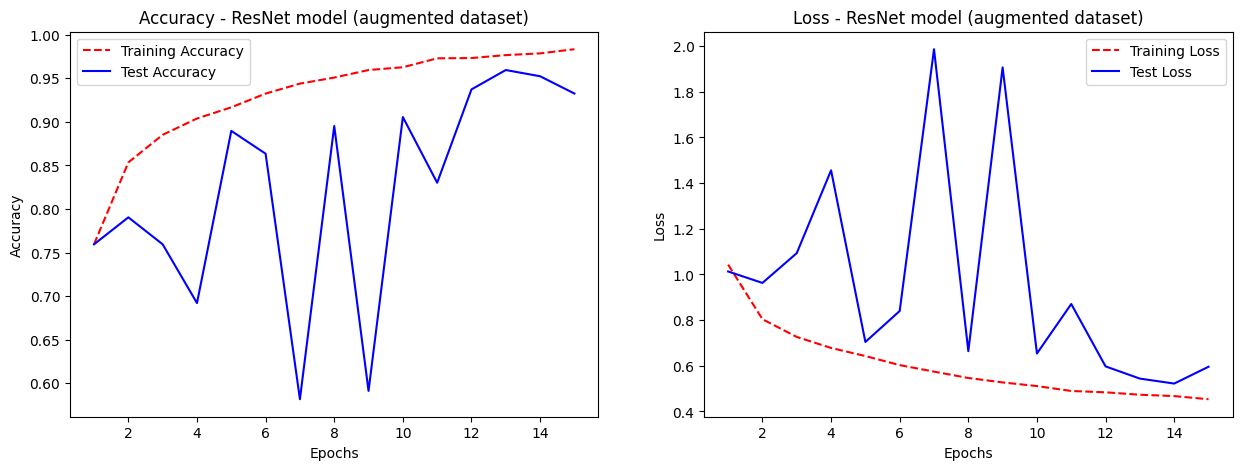

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, len(history_full.history['accuracy']) + 1)
train_loss = history_full.history['loss']
train_accuracy = history_full.history['accuracy']
test_loss = history_full.history.get('val_loss', None)
test_accuracy = history_full.history.get('val_accuracy', None)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Training and test accuracy
ax1.plot(epochs, train_accuracy, 'r--', label='Training Accuracy')
if test_accuracy is not None:
    ax1.plot(epochs, test_accuracy, 'b-', label='Test Accuracy')
ax1.set_title('Accuracy - ResNet model (augmented dataset)')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Training and test loss
ax2.plot(epochs, train_loss, 'r--', label='Training Loss')
if test_loss is not None:
    ax2.plot(epochs, test_loss, 'b-', label='Test Loss')
ax2.set_title('Loss - ResNet model (augmented dataset)')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.savefig('img/resnet_final_learning_curve.png', dpi=300)
plt.show()


40/40 [==============================] - 4s 83ms/step


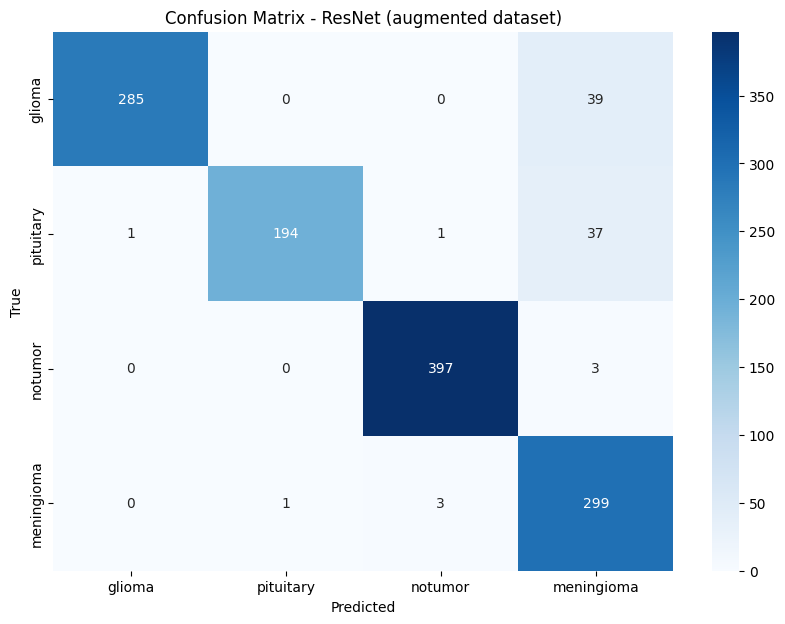

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Make predictions on the test set
y_pred = model_full.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Reverse the label map to get a mapping from index to class name
index_to_class_name = {v: k for k, v in label_map.items()}

# Convert class indices to class names
y_test_names = np.vectorize(index_to_class_name.get)(y_test)
y_pred_classes_names = np.vectorize(index_to_class_name.get)(y_pred_classes)

# Compute the confusion matrix
cm = confusion_matrix(y_test_names, y_pred_classes_names, labels=list(label_map.keys()))

# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Confusion Matrix - ResNet (augmented dataset)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('img/resnet_final_confusion_matrix.png', dpi=300)
plt.show()

In [26]:
print('Classification Report (RESNET MODEL):\n', classification_report(y_test, y_pred_classes))


Classification Report (RESNET MODEL):
               precision    recall  f1-score   support

           0       1.00      0.88      0.93       324
           1       0.99      0.83      0.91       233
           2       0.99      0.99      0.99       400
           3       0.79      0.99      0.88       303

    accuracy                           0.93      1260
   macro avg       0.94      0.92      0.93      1260
weighted avg       0.94      0.93      0.93      1260



In [27]:
print("Once again...\nFINAL RUN - RESNET MODEL (AUGMENTED DATASET)")
print("Evaluation Loss:", loss)
print("Evaluation Accuracy:", accuracy)

Once again...
FINAL RUN - RESNET MODEL (AUGMENTED DATASET)
Evaluation Loss: 0.5959228277206421
Evaluation Accuracy: 0.932539701461792
